In [2]:
# This code is to test a trained dq stepper in the 2d case
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#for live plotting
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

%run 2d_lipm_env.ipynb #imports LIPM Env
from py_bullet_env.bullet_bolt_env import BoltBulletEnv

[0.   0.04 0.09 0.13 0.16 0.19 0.24 0.29 0.35]
[0.   0.04 0.09 0.13 0.15 0.18 0.21 0.25 0.3  0.35]


In [3]:
class NN(nn.Module):
    def __init__(self, inp_size, out_size):
        
        super(NN, self).__init__()
        self.l1 = nn.Linear(inp_size, 512)
        self.l2 = nn.Linear(512, 512)
        self.l3 = nn.Linear(512, 512)
        self.l4 = nn.Linear(512, 512)
        self.l5 = nn.Linear(512, 512)
        self.l6 = nn.Linear(512, 512)
        self.l7 = nn.Linear(512, 512)
        self.l8 = nn.Linear(512, out_size)
    
    def forward(self, x):
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = F.relu(self.l5(x))
        x = F.relu(self.l6(x))
        x = F.relu(self.l7(x))
        x = self.l8(x)
        return x

In [4]:
class TwoDQStepper:
    def __init__(self, no_actions = [9, 7], lr = 1e-4, gamma = 0.9, use_tarnet = False, trained_model = None):
        '''
        This is a 2d dq stepper.
        State = [x-ux, y - uy, xd, yd, n, action_x, action_y]
        '''
        self.device = torch.device("cpu")
        self.dq_stepper = NN(9, 1).to(self.device) #state+ action -> q_value
        if trained_model:
            self.dq_stepper.load_state_dict(torch.load(trained_model))
            self.dq_stepper.eval()
        self.optimizer = torch.optim.SGD(self.dq_stepper.parameters(), lr)
        self.use_tarnet = use_tarnet
        if self.use_tarnet:
            self.dq_tar_stepper = NN(9, 1).to(self.device)
            self.dq_tar_stepper.load_state_dict(self.dq_stepper.state_dict())
            self.dq_tar_stepper.eval()
        self.gamma = gamma #discount factor
        assert len(no_actions) == 2
        self.no_actions = no_actions
        
        # This is the template of x_in that goes into the dq stepper
        self.x_in = np.zeros((self.no_actions[0]*self.no_actions[1], 9))
        self.x_in[:,7] = np.tile(np.arange(self.no_actions[0]), self.no_actions[1])
        self.x_in[:,8] = np.repeat(np.arange(self.no_actions[1]), self.no_actions[0])
                  
    def predict_action_value(self, x):
        # this function predicts the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6]] = x
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
        return [action_x, action_y], q_values[action_index]
    
    def tar_predict_action_value(self, x):
        # this function uses tar net to predict 
        # the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6]] = x
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_tar_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
        return [action_x, action_y], q_values[action_index]
    
    def predict_eps_greedy(self, x, eps = 0.1):
        # This function returns prediction based on epsillon greedy algorithm
        if np.random.random() > eps:
            return self.predict_action_value(x)[0]
        else:
            action_x = np.random.randint(self.no_actions[0])
            action_y = np.random.randint(self.no_actions[1])
            return [action_x, action_y]
        
    def optimize(self, mini_batch, tau = 0.001):
        # This function performs one step of back propogation for the given mini_batch data
        x_in = torch.FloatTensor(mini_batch[:,0:9].copy(), device = self.device)
        y_train = torch.FloatTensor(mini_batch[:,9].copy(), device = self.device)
        for i in range(len(mini_batch)):
            if not np.isnan(mini_batch[i,10:]).all():
                if not self.use_tarnet:
                    y_train[i] += self.gamma * self.predict_action_value(mini_batch[i,10:])[1]
                else:
                    y_train[i] += self.gamma * self.tar_predict_action_value(mini_batch[i,10:])[1]

        y_train = y_train.unsqueeze(1).detach() #ensures that gradients are not computed on this
        x_train = self.dq_stepper(x_in)

        loss = F.mse_loss(x_train, y_train)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.use_tarnet:
            for tar_param, param in zip(self.dq_tar_stepper.parameters(), self.dq_stepper.parameters()):
                tar_param.data.copy_(tar_param.data * (1.0 - tau) + param.data * tau)
                
        return loss
    
    def live_plot(self, history, figsize=(7,5), title='history'):
        clear_output(wait=True)
        plt.figure(figsize=figsize)
        for label,data in history.items():
            plt.plot(data, label=label)
        plt.title(title)
        plt.grid(True)
        plt.xlabel('episode')
        plt.ylim(0, 200)
        plt.legend(loc='top right') # the plot evolves to the right
        plt.show();
        
    def predict_q(self, x):
        #for debugging
        # this function predicts the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6]] = x
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
        return q_values

In [5]:
env = TwoDLipmEnv(0.2, 0.13, 0.22, [1, 3, 0], no_actions= [11, 9])
no_actions = [len(env.action_space_x), len(env.action_space_y)]
print(no_actions)

dqs = TwoDQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, no_actions= no_actions, trained_model='../../models/dqs_2_old')

[11, 9]


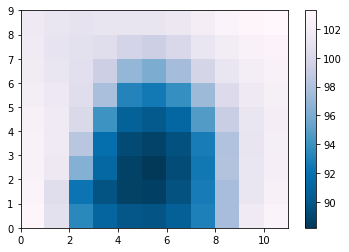

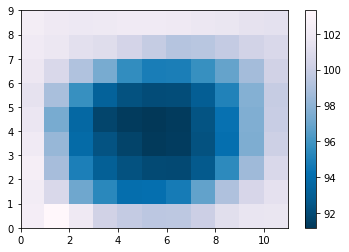

In [6]:
# This block is for visualising the output from the dqstepper
def plot_heatmap(x1, dqs):
    q = dqs.predict_q(x1)
    n = dqs.no_actions
    q_mat = np.zeros((n[1], n[0]))
    for i in range(len(q)):
        q_mat[int(dqs.x_in[i,8]), int(dqs.x_in[i,7])] = q[i]
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(q_mat, cmap='PuBu_r')
    fig.colorbar(heatmap, ax=ax)
    plt.show()

x1 = [0, 0, 0, 0, -1, 0, 0]
x2 = [0, 0, 0, 0, 1, 0, 0]

plot_heatmap(x1, dqs)
plot_heatmap(x2, dqs)

In [7]:
# This block animates the stepper 
no_steps = 20
step_time = 0.1
v_des = [0.5, 0]
v_init = [0.00, 0.0]
state = env.reset_env([0.0, 0.0, v_init[0], v_init[1]], v_des, no_steps*step_time)
print(state)
epi_cost = 0
for n in range(no_steps):
    action = dqs.predict_action_value(state)[0]
    next_state, cost, done = env.step_env(action, step_time)
    print(action, cost, done, state[0:4])
    epi_cost += cost
    state = next_state
    if done:
        print(epi_cost)
        break
print("showing episode...")
env.show_episode(5)

[0.  0.  0.  0.  1.  0.5 0. ]
[4, 4] 2.5876831270415597 False [0. 0. 0. 0.]
[6, 3] 0.9222499212300442 False [ 0.04 -0.08  0.    0.34]
[6, 4] 1.7051055233036392 False [0.01 0.07 0.21 0.01]
[6, 2] 0.6993161702528272 False [-0.   -0.07  0.32  0.38]
[7, 4] 1.378690888501995 False [-0.01  0.04  0.38  0.1 ]
[4, 3] 1.2605368002557271 False [-0.06 -0.1   0.41  0.34]
[6, 3] 1.1107956904354566 False [ 0.01  0.04  0.18 -0.09]
[5, 3] 1.6969883321524 False [-0.01 -0.08  0.26  0.12]
[7, 1] 1.029087281047399 False [ 0.01  0.04  0.25 -0.3 ]
[4, 2] 2.0647415427905202 False [-0.05 -0.03  0.37 -0.19]
[7, 1] 1.3495017605329764 False [ 0.02  0.04  0.21 -0.38]
[5, 3] 2.5272204515141 False [-0.04 -0.04  0.36 -0.29]
[6, 0] 2.26001707740127 False [-0.01  0.05  0.23 -0.56]
[4, 2] 2.8203017178830985 False [-0.03  0.    0.21 -0.43]
[5, 0] 2.1047630965353163 False [ 0.02  0.05  0.08 -0.51]
[6, 2] 1.4984533096206272 False [ 0.03  0.01  0.2  -0.37]
[9, 1] 1.2846641282858708 False [ 0.02  0.06  0.43 -0.42]
[4, 2] 1.6

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAB/7m1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9OSBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAABZVZYiE
ADP//vbsvgU1/Z/QlxEsxdpKcD4qpICAdzTAAAADAAB5FfwSZP1AY4BPTxDXj4KQzU/N/Y99dGHI
szbodIp9ItDG8zk1oVl9zWyV73qUGoiqBOeJN8mOGHAxCggJfYd1k55u6xxibsYAAAMAQRav/fWO
8pMuJ5Z/WyOiduwVKYqkNi8bobDdl+mMbD7knFuX5t1JrjOx2FfMFU9cvQTxNRssIhLTtZKv5vn7
fnWlbf8hI8qKrgu2ZZivB8Lh+peXFJsLxq9b/+yeUgk5azzBpbub6HIfRpojUMd+GHezE9KGTc8y
BZeuv6bpI10n0+9KBIUA+0tLhyBc+wn4E1b/ZtM5qiLFM5oaxCxZQibGP/Hd0wRpHDVQujzybs2h
8oZdmgDPrQ9zjl7Op+YKb4dU/VLNSygvVraF2lPZGbTKBKqD0XScaBtKLI0dnUBr5bEsziRBm6xY
qvO1E0J2IC/rlCVZd41YlXQJjY5yrxBF8NZt/eoSqty63cTozWfqb8syrnD5AZ7g5cVV6xBluMwB
wlreiQxjqW9M5+piZVjNG3WJYsGo7ejTRO66PvzG3L9k3gb1OcbkRbfyjM+DDRyWaO+TjD5C45ds
drI9qwSl9kWdK9B0UemOOSWlZx/ajumbYfCT0k+8JxunEfjHGkv5q+oxZVdhUppXs0kJwxnB8/uN
kWmGPUxzWtwFO3EruWeFuvCHl5W2/RdL3mPIiegk3Rms9XLJ5VFlJwTQQxWc3JDjxNK1Istsd5nd
i4ROCoc3pUe253Blw62QUM6EafMZVSkAkLJXfKfYoRW66LlpsUDTQYlBK3SeAhfY+NUYZhwRS4zV
/0VG5r1Do/dgV6LqWdLEPkWe7YszmBC0bSERfeoAeQxQJpdXKlIuhqj7QXUw6v8USyvKpHYggjJ2
rr9ftvRXw4qoNdylLX0liOSqnhsiD08QL3NgQ6FHv4wO4ZbyCGDI+sklmRQ38S8YgHl0haehYRLp
gefQLuxtT3Adfj2BoVaZB0F5Ue/OvZCb4JDxYQQzMZANIchpDbEDkZIGXRrJsi9mGBhnx8V/M3bP
/9m25fe79P/ngElfU98zIsOaYwVRHX9vXF8Vw3eMy+0a2Wwq8PJNtx1LY5iP/uCSR7JPO4lXEhuc
Rm9xgQ0PaPXn89fM/7FPMy+SBRtjQc+ThLhwve19ddLXOn/ZxhfIylK9M7m/N13vGsFDI0Q+gkUK
XB5Ejh4++jqnFpcFAtHpPYU6A29p/UplMnZRSPcRiAgh6vPSQSGN7Uft7wF9E9v87/feZh6mUF5d
2sxP/jXRN4R3RjMANsGr57ETduahjgfCpa1il9ioT7OEFbhLV7OsgAeOySAW9v+83KiKsUOC3+OV
Iby7WMAk6pvFbB5ULfBo0dPnHRtIaNSgF66OXN+jL/ZboYMxfKx10kxEZHwWGHCpaP0eb1HXnhiw
WaSyP07XOnHyjslnFQii8iOilgq+xkkHz0ycl1Zn1g/DSKA/j1414yb0OXc4lDr3NQndDQa1wA7e
LSFl9Yvl8o4EPQNgUhf4h7/w4+PT6w83UbEBKt7nNIkVV433xgVWAx+dHIlWc5V/Y5B7t2WSeEYd
fTM2UX4Ac4vGwMNh0RCfGyy3C9ssJnIIB7/AnLMjh38FowtGaHQdm9AzP9nLpOVSQVjJ4PsVH3re
zYmeKS5OfpEaqugO76M+JRebCR/JHh5sGdTQF/xyK7WnjrNM0Bk178s4hbCnPBWs08yKAjYQJmWg
F6XAynt/ELBLlbsIDdvlTCKrJaUFicCm1on3atUehjIln5PIRyVH/4u4F4e2QSfItOr8unPqvduk
D77XlTQmyg4ktzk//P6OfUM4SZmttwEOMwtpwDtIPzQOozdzk+sGQH6xWjslyIqjXpScp4xcDlfW
D0xB7FRB0xzWnqD98+jzqDXWGAhoJ9D+WH+71/vqyGTdtm4pklANq21YBzcem2CBWMbbnr2cCbBJ
JhG4oMdqA056KiUviSva4iwHEzsLPzkrxR2tr5pv60nFtWwXPeZiq7lqZTpX/L6wkM+AemuJWeBb
MN1Lao+nsen36YklX4tqnZfyXQDKLHv828zmHB29lRapiHWGz50kMoiEFu4sZIkIB4lpJespH5NA
Td3EmtCSA5B97D0pO3A1K/+Oog7naE2CSiHUVafDIO7rIvnfhg0scuuzQXaA9f/MGxIfxsLH5ELS
/Apie/mj5FrvDOm9MgTwwKxwz16s/wYGUp6h9TE0kh0YipvGLbmFdYBwAfLezNw2koZrBBRaJPH/
9M5H4PfOHCtn7zEL4uUVwLBpRET/xiJZ4IlbUJFPfksFcVg9/AnABKFbIF1r7qulEEXbkawPWIxd
rlFCiFMsCPqWy9529wEalm5E6ttlrOBh//1qVqV6NGTFjWSxWOBOxONk+mnGlLy7QEWBGzfwEnrk
h1usj2pHsilnXwwqZPq8cJidpGskRf2GJPwL63Yu7jMVf0dyEWJ6mb2rRCzjdb2fvBn8JEUXJIRX
liRGYKDE5BJBqPLf7+TCJYtrCMysIDTNz3H7I1AJz0WSZ9TVwlArN1Q7vSl88doIjwn534C2GhqN
ldNWUl7QPBtCBT1oIKB8OqnfkJWp3IA6XMv8fT8OHFhO46D5srDalMksMHphWNCoZeHvqYcYiMT/
ODnXnOh4Giwe4CDFw9yK6Lv/r/FHd93yBPo6RH9B+4SBRoMSXDuDfMNKbFp8qHv/RehmxRPpFtCP
6Mn7txf7+4nL1j4i98KvaDEaZwpXaSVIf06xd2ZAYGI5pFjRptaubZAd+DvDlcJMs4W+bjjiG2Jl
/iwjRegNmQAF60ifBopLg3/6f14IpBhauYHnv/8MZ3BEYeah/UbRgJX69wy3lq4Ea5CpijRZnv5W
FwlyDKqTdQszjXRK80JQU

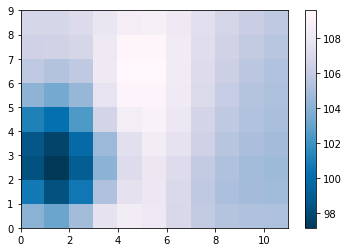

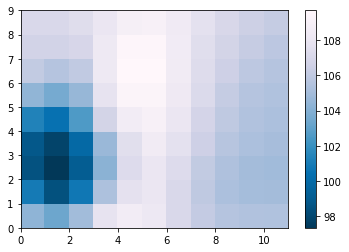

In [7]:
# This block creates the regularizing matrix
no_actions = [len(env.action_space_x), len(env.action_space_y)]
q_mat = np.zeros((no_actions[1], no_actions[0]))
reg_mat = np.zeros((no_actions[1], no_actions[0]))

for y in range(reg_mat.shape[0]):
    for x in range(reg_mat.shape[1]):
        reg_mat[y][x] = np.linalg.norm([env.action_space_x[x], env.action_space_y[y] - env.b])
        
def plot_reg_heatmap(x1, dqs, w):
    q = dqs.predict_q(x1)
    n = dqs.no_actions
    q_mat = np.zeros((n[1], n[0]))
    for i in range(len(q)):
        q_mat[int(dqs.x_in[i,8]), int(dqs.x_in[i,7])] = q[i]
    q_mat += w*reg_mat
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(q_mat, cmap='PuBu_r')
    fig.colorbar(heatmap, ax=ax)
    plt.show()

x1 = [0, 0, -1, 0, -1, 0, 0]

plot_reg_heatmap(x1, dqs, 0)
plot_reg_heatmap(x1, dqs, 1)


In [7]:
# This block is to test the dq stepper on bolt in pybullet
kp = [100, 100, 100]
kd = [1, 1, 1]
kp_com = [100, 100, 100]
kd_com = [2, 2, 30]
kp_ang_com = [100, 100, 100]
kd_ang_com = [100, 100, 100]

step_time = 0.1
stance_time = 0.01
ht = 0.2

bolt_env = BoltBulletEnv(ht, step_time, stance_time, kp, kd, kp_com, kd_com, kp_ang_com, kd_ang_com)

In [ ]:
# stepping with regularizing
w = 1.0
q_mat = np.zeros((no_actions[1], no_actions[0]))
reg_mat = np.zeros((no_actions[1], no_actions[0]))
for y in range(reg_mat.shape[0]):
    for x in range(reg_mat.shape[1]):
        reg_mat[y][x] = np.linalg.norm([env.action_space_x[x], env.action_space_y[y] - env.b])

no_steps = 50
des_com = [0.0, 0, ht]
des_vel = [1.0, 0, 0]
x_ori = [0, 0, 0, 1]
x_angvel = [0, 0, 0]

x, xd, u, n = bolt_env.reset_env()
state = [x[0] - u[0], x[1] - u[1], xd[0], xd[1], n, des_vel[0], des_vel[1]]
bolt_env.update_gains([35, 35, 25], [10, 10, 10], [0, 0, 20], [0, 0, 10], [60, 60, 0], [60, 60, 0])

for i in range(no_steps):
    q = dqs.predict_q(state)
    for i in range(len(q)):
        q_mat[int(dqs.x_in[i,8]), int(dqs.x_in[i,7])] = q[i]
    
    q_mat = q_mat + w*reg_mat
#     fig, ax = plt.subplots()
#     heatmap = ax.pcolor(q_mat, cmap='PuBu_r')
#     fig.colorbar(heatmap, ax=ax)
#     plt.show()

    # Note : index is swapped because x is cols in q_mat    
    action = np.unravel_index(q_mat.argmin(), q_mat.shape)
    u_x = env.action_space_x[action[1]] + u[0]
    u_y = n*env.action_space_y[action[0]] + u[1]
    x, xd, u_new, n = bolt_env.step_env([u_x, u_y], des_com, des_vel, x_ori, x_angvel)
    print(action[1], action[0], x - u_new, xd)
    u = u_new
    state = [x[0] - u[0], x[1] - u[1], xd[0], xd[1], n, des_vel[0], des_vel[1]]


3 3 [ 0.09 -0.11] [-0.03  0.11]
8 3 [-0.03  0.01] [ 0.25 -0.24]
6 1 [-0.06 -0.02] [ 0.17 -0.26]
3 3 [0.03 0.12] [-0.06 -0.35]
4 3 [0.07 0.  ] [0.03 0.05]
7 1 [0.   0.03] [0.34 0.18]
7 5 [-0.09 -0.18] [0.34 0.32]
3 6 [0.01 0.06] [0.26 0.11]
6 5 [-0.03 -0.12] [0.23 0.41]
4 4 [0.02 0.03] [0.3  0.02]
7 4 [-0.07 -0.14] [0.36 0.2 ]
3 6 [0.05 0.08] [0.32 0.05]
8 4 [-0.07 -0.07] [0.28 0.49]
3 2 [ 0.03 -0.01] [0.26 0.21]
7 5 [-0.07 -0.2 ] [0.32 0.34]
3 7 [0.06 0.04] [0.19 0.37]
7 6 [-0.02 -0.2 ] [0.23 0.59]
5 6 [-0.03 -0.02] [-0.07  0.78]
2 8 [ 0.16 -0.24] [ 1.11 -0.81]
4 2 [ 0.25 -0.1 ] [1.76 0.9 ]
4 3 [ 0.26 -0.24] [-0.19 -0.54]
4 2 [ 0.18 -0.04] [-0.59 -1.31]
0 5 [0.15 0.  ] [0.92 2.35]
10 8 [-0.04  0.12] [-3.8   1.67]
10 6 [-0.13 -0.11] [-0.09  3.13]
10 8 [-0.21  0.05] [3.67 2.04]
8 0 [-0.03 -0.04] [23.03  1.45]
10 8 [-0.03  0.07] [-12.24  -5.55]
10 8 [0.08 0.2 ] [-11.22  25.58]
10 8 [-0.16 -0.1 ] [-19.15  33.91]
10 8 [-0.2   0.24] [-13.01  -1.19]
10 8 [0.06 0.17] [ 13.41 -55.27]
10 8 [ 0.0